In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
# this function generates an item bank, in case the user cannot provide one
from catsim.cat import generate_item_bank
# simulation package contains the Simulator and all abstract classes
from catsim.simulation import *
# initialization package contains different initial proficiency estimation strategies
from catsim.initialization import *
# selection package contains different item selection strategies
from catsim.selection import *
# estimation package contains different proficiency estimation methods
from catsim.estimation import *
# stopping package contains different stopping criteria for the CAT
from catsim.stopping import *
import catsim.plot as catplot
from catsim.irt import icc
from catsim.irt import detect_model


# this function generates an item bank, in case the user cannot provide one
from catsim.cat import generate_item_bank
# simulation package contains the Simulator and all abstract classes
from catsim.simulation import *
# initialization package contains different initial proficiency estimation strategies
from catsim.initialization import *
# selection package contains different item selection strategies
from catsim.selection import *
# estimation package contains different proficiency estimation methods
from catsim.estimation import *
# stopping package contains different stopping criteria for the CAT
from catsim.stopping import *
import catsim.plot as catplot
from catsim.irt import icc

C:\Users\patri\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
def info_fisher(A, B, C, D, thetas):
    gg = 1 + np.exp(-D*A*(thetas - B))
    g = np.exp(-D*A*(thetas - B))
    info = ((1-C)*D*A)**2*g/ gg**2 / ((C*(g-1) - C**2*g + 1))
    return info


def KLP(blf,thetasB,probsB,logprobsB,log1_probsB,T):

    res = np.shape(probsB)
    
    nQ = res[0]
    nA = res[1]
    
    ind = np.argmin(abs(thetasB-T));
    
    probAcertar = np.tile(probsB[:,[ind]],(1,nA))
    logprobAcertar = np.tile(logprobsB[:,[ind]] ,(1,nA))
    log1_probAcertar = np.tile(log1_probsB[:,[ind]],(1,nA))
  

    klp = probAcertar*(logprobAcertar-logprobsB) + (1-probAcertar)*(log1_probAcertar-log1_probsB)
  
    retorno = blf@klp.T
    return retorno

In [65]:
# repete = 200;
# nA = 25;

# repete = 1;
# nA = 50;

repete = 2;
nA = 1000;

nQ = 50;
maxnQ = min(25,nQ);

# Maximum Likelihood Parameters 

rateGrow = 0.25;
maxGrow = 2;

estimator = 3
estName = ['EAP','MAP','ML']
base = 3
baseName = ['norm','uni','peak']
shift = 1

nSC = 6;

thetasA = np.random.randn(nA)


if base == 1:
    Bs = shift+np.random.normal(size=nQ)
elif base == 2:
    Bs = shift+(np.random.rand(nQ)*6-3)
elif base == 3:
    Bs = shift+np.concatenate((np.random.normal(size=(int(nQ/2))), (np.random.rand(int(nQ/2))*6-3)),axis=0)
    

As = np.random.lognormal(0,0.35,size=nQ)
Cs = np.random.beta(1,4,size=nQ)
D = np.array(1.702,ndmin=1)

thetasB = np.arange(-4,4,0.001)
nB = len(thetasB)


blf0 =  norm.pdf(thetasB)
blf0 = blf0/np.sum(blf0)

probsB = np.zeros((nQ,nB))
probsA = np.zeros((nQ,nA))
infos = np.zeros((nQ,nB))


for q in np.arange(0,nQ):
    probsA[q,:] = (Cs[q] + (1-Cs[q])/( 1 + np.exp(-D*As[q]*( thetasA - Bs[q]  ) )   ))
    probsB[q,:] = (Cs[q] + (1-Cs[q])/( 1 + np.exp(-D*As[q]*( thetasB - Bs[q]  ) )   ))
    infos[q,:] =  ((1-Cs[q])*D*As[q]*np.exp(-D*As[q]*( thetasB - Bs[q]  ) )/ (1 + np.exp(-D * As[q] * ( thetasB - Bs[q]  ) ))**2 )**2/( probsB[q,:]*(1-probsB[q,:]) )
    infos[q,:] =  info_fisher(As[q],Bs[q],Cs[q],D,thetasB)


logprobsB = np.log(probsB);
log1_probsB = np.log(1-probsB);


In [6]:
globalMSE = []
globalthetaB = []
for sc in range(0,nSC):
  globalMSE.append([])
  globalthetaB.append([])

globalthetasA = []

respA = probsA > np.random.rand(nQ,nA)

thetaB = np.zeros((nA,maxnQ+1))
    
    
infosTotal = np.zeros((nQ,len(thetasB)));

for q in range(0,nQ):
    infosTotal[q,:] = info_fisher(As[q],Bs[q],Cs[q],D,thetasB);

for sc in range(0,nSC):
  
  print(sc)
  for a in range(0,nA):

    if np.remainder(a+1,100) == 0:
        print(sc,a/nA)

    blf = blf0
    applied = np.zeros(nQ)

    for q in np.arange(0,maxnQ):

      if estimator == 1:
        # EAP
        T = np.sum(blf*thetasB)
      elif estimator == 2:
        # MAP
        aux = np.argmax(blf)
        T = thetasB[0,aux]
      elif estimator == 3:
        # ML
        if q>0:
          qs = np.flatnonzero(np.isinf(applied))
          if np.min(  respA[qs, a] == 0 ):     # min (python) = all (matlab)
            T = np.max([-maxGrow,-len(qs)*rateGrow])
          elif np.min(  respA[qs, a] == 1 ):
            T = np.min([maxGrow,len(qs)*rateGrow])
          else:
            aux = np.argmax(blf/blf0)
            T = thetasB[aux]
        else:
          T = 0

      if sc == 0:
        I = info_fisher(As,Bs,Cs,D,T)
        vv = np.max(I+applied)
        qq = np.argmax(I+applied)


      elif sc == 1:
        aux = np.flatnonzero(applied==0)
        qq = aux[np.random.randint(len(aux))]

      elif sc == 2:
        kl = KLP(blf/blf0,thetasB,probsB,logprobsB,log1_probsB,T)
        vv = np.max(kl+applied)
        qq = np.argmax(kl+applied)

      elif sc == 3:
        klp = KLP(blf,thetasB,probsB,logprobsB,log1_probsB,T)
        vv = np.max(klp+applied)
        qq = np.argmax(klp+applied)

      elif sc == 4:
        mlwi = (blf/blf0)@infosTotal.T
        vv = np.max(mlwi+applied)
        qq = np.argmax(mlwi+applied)

      elif sc == 5:
        mpwi = blf@infosTotal.T
        vv = np.max(mpwi+applied)
        qq = np.argmax(mpwi+applied)

      # elif sc == 6:
        # er = ExpRed(blf,thetasB,probsB)
        # vv = np.max(er+applied)
        # qq = np.argmax(er+applied)

      if respA[qq,a] == 1:
          blf = blf*probsB[qq,:]
      else:
          blf = blf*(1-probsB[qq,:])

      blf = blf/sum(blf);
      thetaB[a,q] = T;
      applied[qq] = -np.inf;

    if estimator == 1:
      # EAP
      T = np.sum(blf*thetasB)
    elif estimator == 2:
      # MAP
      aux = np.argmax(blf)
      T = thetasB[0,aux]
    elif estimator == 3:
      # ML
      if q>0:
        qs = np.flatnonzero(np.isinf(applied))
        if np.min(  respA[qs, a] == 0 ):     # min (python) = all (matlab)
          T = np.max([-maxGrow,-len(qs)*rateGrow])
        elif np.min(  respA[qs, a] == 1 ):
          T = np.min([maxGrow,len(qs)*rateGrow])
        else:
          aux = np.argmax(blf/blf0)
          T = thetasB[aux]
      else:
        T = 0
          
    thetaB[a,q+1] = T

  MSE = (thetaB-np.tile(thetasA,(maxnQ+1,1)).T)**2
  globalMSE[sc].append(MSE)
  globalthetaB[sc].append(thetaB)
  globalthetasA.append(thetasA)


0
0 0.099
0 0.199
0 0.299
0 0.399
0 0.499
0 0.599
0 0.699
0 0.799
0 0.899
0 0.999
1
1 0.099
1 0.199
1 0.299
1 0.399
1 0.499
1 0.599
1 0.699
1 0.799
1 0.899
1 0.999
2
2 0.099
2 0.199
2 0.299
2 0.399
2 0.499
2 0.599
2 0.699
2 0.799
2 0.899
2 0.999
3
3 0.099
3 0.199
3 0.299
3 0.399
3 0.499
3 0.599
3 0.699
3 0.799
3 0.899
3 0.999
4
4 0.099
4 0.199
4 0.299
4 0.399
4 0.499
4 0.599
4 0.699
4 0.799
4 0.899
4 0.999
5
5 0.099
5 0.199
5 0.299
5 0.399
5 0.499
5 0.599
5 0.699
5 0.799
5 0.899
5 0.999


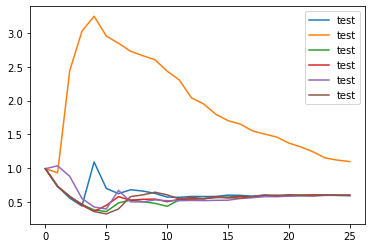

In [7]:
for sc in range(nSC):
  plt.plot(np.mean(globalMSE[sc][0],axis=0), label="test")
plt.legend()

# Base ENEM

In [74]:
alunos = pd.read_excel('C:/Users/patri/Desktop/CAT-GYM/file1000.xlsx')
param = pd.read_excel('C:/Users/patri/Desktop/CAT-GYM/Calibração/parametros.xlsx')
theta_original = np.loadtxt('Result_theta_original-base1000.txt')

In [102]:
# repete = 200;
# nA = 25;

# repete = 1;
# nA = 50;

repete = 2;
nA = 1000;

nQ = 45;
maxnQ = min(25,nQ);

# Maximum Likelihood Parameters 

rateGrow = 0.25;
maxGrow = 2;

estimator = 3
estName = ['EAP','MAP','ML']
base = 1
# baseName = ['alunos']
shift = 1

nSC = 6;

# thetasA = np.random.randn(nA)
thetasA = theta_original

As = param.iloc[0:45,1].to_numpy()
Bs = param.iloc[0:45,2].to_numpy()
Cs = param.iloc[0:45,3].to_numpy()
D = np.array(1,ndmin=1)
# if base == 1:
#     Bs = shift+np.random.normal(size=nQ)
# elif base == 2:
#     Bs = shift+(np.random.rand(nQ)*6-3)
# elif base == 3:
#     Bs = shift+np.concatenate((np.random.normal(size=(int(nQ/2))), (np.random.rand(int(nQ/2))*6-3)),axis=0)

# As = np.random.lognormal(0,0.35,size=nQ)
# Cs = np.random.beta(1,4,size=nQ)
# D = np.array(1.702,ndmin=1)

thetasB = np.arange(-4,4,0.001)
nB = len(thetasB)

blf0 =  norm.pdf(thetasB)
blf0 = blf0/np.sum(blf0)

probsB = np.zeros((nQ,nB))
probsA = np.zeros((nQ,nA))
infos = np.zeros((nQ,nB))


for q in np.arange(0,nQ):
    probsA[q,:] = (Cs[q] + (1-Cs[q])/( 1 + np.exp(-D*As[q]*( thetasA - Bs[q]  ) )   ))
    probsB[q,:] = (Cs[q] + (1-Cs[q])/( 1 + np.exp(-D*As[q]*( thetasB - Bs[q]  ) )   ))
    infos[q,:] =  ((1-Cs[q])*D*As[q]*np.exp(-D*As[q]*( thetasB - Bs[q]  ) )/ (1 + np.exp(-D * As[q] * ( thetasB - Bs[q]  ) ))**2 )**2/( probsB[q,:]*(1-probsB[q,:]) )
    infos[q,:] =  info_fisher(As[q],Bs[q],Cs[q],D,thetasB)


logprobsB = np.log(probsB);
log1_probsB = np.log(1-probsB);

In [103]:
globalMSE = []
globalthetaB = []
for sc in range(0,nSC):
  globalMSE.append([])
  globalthetaB.append([])

globalthetasA = []

# respA = probsA > np.random.rand(nQ,nA)
respA = (alunos.iloc[:,0:45].to_numpy()).T

thetaB = np.zeros((nA,maxnQ+1))
    
infosTotal = np.zeros((nQ,len(thetasB)));

for q in range(0,nQ):
    infosTotal[q,:] = info_fisher(As[q],Bs[q],Cs[q],D,thetasB);

for sc in range(0,nSC):
  
  print(sc)
  for a in range(0,nA):

    if np.remainder(a+1,100) == 0:
        print(sc,a/nA)

    blf = blf0
    applied = np.zeros(nQ)

    for q in np.arange(0,maxnQ):

      if estimator == 1:
        # EAP
        T = np.sum(blf*thetasB)
      elif estimator == 2:
        # MAP
        aux = np.argmax(blf)
        T = thetasB[0,aux]
      elif estimator == 3:
        # ML
        if q>0:
          qs = np.flatnonzero(np.isinf(applied))
          if np.min(  respA[qs, a] == 0 ):     # min (python) = all (matlab)
            T = np.max([-maxGrow,-len(qs)*rateGrow])
          elif np.min(  respA[qs, a] == 1 ):
            T = np.min([maxGrow,len(qs)*rateGrow])
          else:
            aux = np.argmax(blf/blf0)
            T = thetasB[aux]
        else:
          T = 0

      if sc == 0:
        I = info_fisher(As,Bs,Cs,D,T)
        vv = np.max(I+applied)
        qq = np.argmax(I+applied)


      elif sc == 1:
        aux = np.flatnonzero(applied==0)
        qq = aux[np.random.randint(len(aux))]

      elif sc == 2:
        kl = KLP(blf/blf0,thetasB,probsB,logprobsB,log1_probsB,T)
        vv = np.max(kl+applied)
        qq = np.argmax(kl+applied)

      elif sc == 3:
        klp = KLP(blf,thetasB,probsB,logprobsB,log1_probsB,T)
        vv = np.max(klp+applied)
        qq = np.argmax(klp+applied)

      elif sc == 4:
        mlwi = (blf/blf0)@infosTotal.T
        vv = np.max(mlwi+applied)
        qq = np.argmax(mlwi+applied)

      elif sc == 5:
        mpwi = blf@infosTotal.T
        vv = np.max(mpwi+applied)
        qq = np.argmax(mpwi+applied)

      # elif sc == 6:
        # er = ExpRed(blf,thetasB,probsB)
        # vv = np.max(er+applied)
        # qq = np.argmax(er+applied)

      if respA[qq,a] == 1:
          blf = blf*probsB[qq,:]
      else:
          blf = blf*(1-probsB[qq,:])

      blf = blf/sum(blf);
      thetaB[a,q] = T;
      applied[qq] = -np.inf;

    if estimator == 1:
      # EAP
      T = np.sum(blf*thetasB)
    elif estimator == 2:
      # MAP
      aux = np.argmax(blf)
      T = thetasB[0,aux]
    elif estimator == 3:
      # ML
      if q>0:
        qs = np.flatnonzero(np.isinf(applied))
        if np.min(  respA[qs, a] == 0 ):     # min (python) = all (matlab)
          T = np.max([-maxGrow,-len(qs)*rateGrow])
        elif np.min(  respA[qs, a] == 1 ):
          T = np.min([maxGrow,len(qs)*rateGrow])
        else:
          aux = np.argmax(blf/blf0)
          T = thetasB[aux]
      else:
        T = 0
          
    thetaB[a,q+1] = T

  MSE = (thetaB-np.tile(thetasA,(maxnQ+1,1)).T)**2
  globalMSE[sc].append(MSE)
  globalthetaB[sc].append(thetaB)
  globalthetasA.append(thetasA)

0
0 0.099
0 0.199
0 0.299
0 0.399
0 0.499
0 0.599
0 0.699
0 0.799
0 0.899
0 0.999
1
1 0.099
1 0.199
1 0.299
1 0.399
1 0.499
1 0.599
1 0.699
1 0.799
1 0.899
1 0.999
2
2 0.099
2 0.199
2 0.299
2 0.399
2 0.499
2 0.599
2 0.699
2 0.799
2 0.899
2 0.999
3
3 0.099
3 0.199
3 0.299
3 0.399
3 0.499
3 0.599
3 0.699
3 0.799
3 0.899
3 0.999
4
4 0.099
4 0.199
4 0.299
4 0.399
4 0.499
4 0.599
4 0.699
4 0.799
4 0.899
4 0.999
5
5 0.099
5 0.199
5 0.299
5 0.399
5 0.499
5 0.599
5 0.699
5 0.799
5 0.899
5 0.999


No handles with labels found to put in legend.


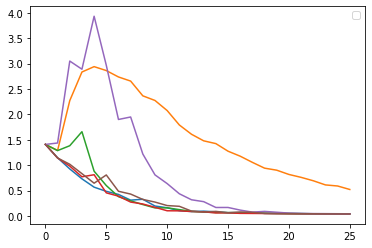

In [106]:
# labels = ["fisher","aleat","KL","KLP","mlwi","mpwi"]
# label="labels"

for sc in range(nSC):
  plt.plot(np.mean(globalMSE[sc][0],axis=0))
plt.legend()